In [1]:
#importing libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [2]:
beer = pd.read_csv('data/recipeData.csv', index_col='BeerID', encoding='latin1')

In [3]:
beer.shape

(73861, 21)

In [4]:
beer.head()

,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,...,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount
BeerID,,,,,,,,,,,,,,,,,,,,,
1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,4.83,...,75,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz
2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,15.64,...,60,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,8.98,...,60,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN
4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,8.50,...,60,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,4.57,...,90,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l


In [5]:
stylecounts = pd.DataFrame(beer['Style'].value_counts().reset_index())
stylecounts.loc[stylecounts['Style']>400,:]


,index,Style
0,American IPA,11940
1,American Pale Ale,7581
2,Saison,2617
3,American Light Lager,2277
4,American Amber Ale,2038
5,Blonde Ale,1753
6,Imperial IPA,1478
7,American Stout,1268
8,Irish Red Ale,1204
9,American Brown Ale,1152


In [6]:
a = beer['Imperial IPA'] = (beer['Style'].str.contains('Imperial IPA'or'Double IPA'))*'Imperial IPA '


In [7]:
v = beer['IPA'] = (beer['Style'].str.contains(' IPA'))*'IPA'


In [8]:
c = beer['Pale Ale'] = (beer['Style'].str.contains('Pale Ale'))*'Pale Ale'

In [9]:
d = beer['Light Lager'] = (beer['Style'].str.contains('Light Lager'))*'Light Lager '

In [10]:
o = beer['Lager'] = (beer['Style'].str.contains(' Lager'))*'Lager'

In [11]:
e =beer['Blonde Ale'] = (beer['Style'].str.contains('Blonde Ale' or 'Blond Ale'))*'Blonde Ale'

In [12]:
f = beer['Imperial Stout'] = (beer['Style'].str.contains('Imperial Stout'))*'Imperial Stout '

In [13]:
#g = beer['Oatmeal Stout'] = (beer['Style'].str.contains('Oatmeal Stout'))*'Oatmeal Stout '

In [14]:
#h = beer['Sweet Stout'] = (beer['Style'].str.contains('Sweet Stout'))*'Sweet Stout '

In [15]:
j = beer['Saison'] = (beer['Style'].str.contains('Saison'))*'Saison'

In [16]:
k = beer['Stout'] = (beer['Style'].str.contains(' Stout'))*'Stout' 

In [17]:
l = beer['Red Ale'] = (beer['Style'].str.contains('Red Ale'))*'Red Ale'

In [18]:
m = beer['Brown Ale'] = (beer['Style'].str.contains('Brown Ale'))*'Brown Ale'

In [19]:
#n = beer['Cream Ale'] = (beer['Style'].str.contains('Cream Ale'))*'Cream Ale'

In [20]:
q = beer['Wheat Beer'] = (beer['Style'].str.contains('Witbier' or 'Weissbier' or 'Weizenbier' or 'Weizen/Weissbier' or 'Wheat Beer' or 'Rye Beer'or 'Roggenbier'))*'Wheat Beer'

In [21]:
#s = beer['Kölsch'] = (beer['Style'].str.contains('Kölsch'))*'Kölsch'

In [22]:
t = beer['Porter'] = (beer['Style'].str.contains(' Porter'))*'Porter'

In [23]:
u = beer['Common Beer'] = (beer['Style'].str.contains(' Common' or ' Steam'))*'Common Beer'

In [24]:
p = beer['Strong Bitter'] = (beer['Style'].str.contains('Strong Bitter'))*'Strong Bitter'

In [25]:
beer['kind'] = a+c+d+e+f+j+k+l+m+o+p+q+t+u+v+''
beer['kind'].value_counts()

                        24470
IPA                     15586
Pale Ale                 8206
Stout                    4350
Porter                   2700
Saison                   2617
Light Lager Lager        2277
Lager                    1833
Blonde Ale               1753
Imperial Stout Stout     1604
Brown Ale                1601
Imperial IPA IPA         1478
Red Ale                  1349
Common Beer              1229
Strong Bitter            1140
Wheat Beer               1072
Name: kind, dtype: int64

In [26]:
beer2 = pd.DataFrame(beer.iloc[:,:-16])

In [27]:
beer2.head()

,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,...,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount
BeerID,,,,,,,,,,,,,,,,,,,,,
1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,4.83,...,75,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz
2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,15.64,...,60,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,8.98,...,60,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN
4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,8.50,...,60,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,4.57,...,90,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l


In [28]:
beer2['kind'] = beer['kind']

In [29]:
beer2['kind'] =  beer2['kind'].replace('',np.nan)

In [30]:
beer2['kind'].value_counts()

IPA                     15586
Pale Ale                 8206
Stout                    4350
Porter                   2700
Saison                   2617
Light Lager Lager        2277
Lager                    1833
Blonde Ale               1753
Imperial Stout Stout     1604
Brown Ale                1601
Imperial IPA IPA         1478
Red Ale                  1349
Common Beer              1229
Strong Bitter            1140
Wheat Beer               1072
Name: kind, dtype: int64

In [31]:
## Count nulls 
null_count = beer2.isnull().sum()
null_count[null_count>0]

Name                 1
Style              596
BoilGravity       2990
MashThickness    29864
PitchRate        39252
PrimaryTemp      22662
PrimingMethod    67095
PrimingAmount    69087
kind             25066
dtype: int64

PrimingMethod and PrimingAmount have too many nulls to be useful.

In [32]:
beer2 = beer2.drop(columns = ['PrimingMethod','PrimingAmount','URL','Name'])

I'm replacing the style column with my 'kind' column.

In [33]:
beer2 = beer2.drop(columns = ['Style'])

PitchRate also has an awful lot of nan values. I'll do a histogram to see if the nan values are consistent across all styles.

In [34]:
beer2.PitchRate.describe()

count    34609.000000
mean         0.750468
std          0.394262
min          0.000000
25%          0.350000
50%          0.750000
75%          1.000000
max          2.000000
Name: PitchRate, dtype: float64

In [35]:
beer2['PrimaryTemp'].describe()

count    51199.000000
mean        19.175641
std          4.219676
min        -17.780000
25%         18.000000
50%         20.000000
75%         20.000000
max        114.000000
Name: PrimaryTemp, dtype: float64

In [36]:
beer2['MashThickness'].describe()

count    43997.000000
mean         2.127235
std          1.682347
min          0.000000
25%          1.500000
50%          1.500000
75%          3.000000
max        100.000000
Name: MashThickness, dtype: float64

The counts for MashThickness, PitchRate and PrimaryTemp are fairly high. We can keep these features if they don't seem skewed toward one style or another.

In [37]:
beergroup = pd.DataFrame(beer2.groupby('StyleID')['MashThickness'].count().reset_index())

In [38]:
beergroup2 = pd.DataFrame(beer2.groupby('StyleID')['PrimaryTemp'].count().reset_index())

In [39]:
beergroup3 = pd.DataFrame(beer2.groupby('StyleID')['PitchRate'].count().reset_index())

In [40]:
beergroup.head()

,StyleID,MashThickness
0,1,95
1,2,22
2,3,11
3,4,1139
4,5,214


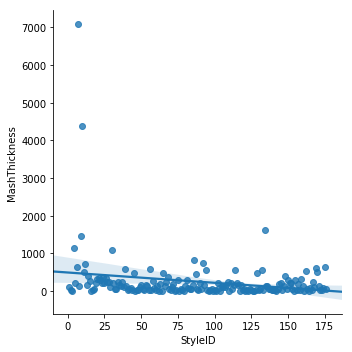

In [41]:
sns.lmplot(x = 'StyleID', y = 'MashThickness', data = beergroup)

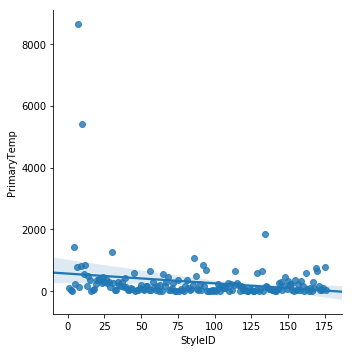

In [42]:
sns.lmplot(x = 'StyleID', y = 'PrimaryTemp', data = beergroup2)

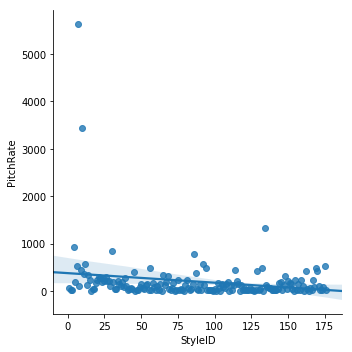

In [43]:
sns.lmplot(x = 'StyleID', y = 'PitchRate', data = beergroup3)

The available values for all of these seem to pretty consistent across styles. These columns could be useful. Let's do a correlation matrix to see if we actually need them.

In [44]:
beer.corr()

,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,PitchRate,PrimaryTemp
StyleID,1.000000,-0.006522,0.002699,0.007336,0.006617,-0.141124,0.166669,-0.006301,0.077969,0.002326,0.021515,0.006167,0.079123,-0.019661
Size(L),-0.006522,1.000000,0.162237,0.141614,-0.013527,-0.029917,-0.018068,0.994143,0.044848,0.176071,0.108826,0.019246,0.026623,0.004278
OG,0.002699,0.162237,1.000000,0.936347,0.029432,-0.001655,0.013632,0.165162,0.031825,0.968138,0.067610,0.046841,0.020556,0.000518
FG,0.007336,0.141614,0.936347,1.000000,0.026851,-0.000719,0.029848,0.142974,0.028930,0.908611,0.061173,0.040541,0.013446,0.004477
ABV,0.006617,-0.013527,0.029432,0.026851,1.000000,0.290889,0.271332,-0.009800,0.120629,0.025421,0.047853,-0.069633,0.132699,0.060065
IBU,-0.141124,-0.029917,-0.001655,-0.000719,0.290889,1.000000,0.060283,-0.028258,0.078694,-0.007498,-0.033172,-0.044381,0.006180,0.035510
Color,0.166669,-0.018068,0.013632,0.029848,0.271332,0.060283,1.000000,-0.016798,0.058089,0.013451,-0.017297,-0.038406,0.016061,0.025622
BoilSize,-0.006301,0.994143,0.165162,0.142974,-0.009800,-0.028258,-0.016798,1.000000,0.051219,0.175972,0.121971,0.017772,0.030936,0.003000
BoilTime,0.077969,0.044848,0.031825,0.028930,0.120629,0.078694,0.058089,0.051219,1.000000,0.026921,0.161295,0.006850,0.190922,-0.079809
BoilGravity,0.002326,0.176071,0.968138,0.908611,0.025421,-0.007498,0.013451,0.175972,0.026921,1.000000,0.059132,0.050944,0.016216,0.002268


These 3 columns don't seem to correlated strongly with anything else. I'll keep them.

(0, 10)

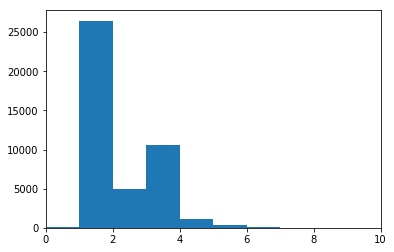

In [45]:
plt.hist(beer2['MashThickness'].dropna(),bins = 100)
plt.xlim(0,10)

{'boxes': [<matplotlib.lines.Line2D at 0x115a112e8>],
 'caps': [<matplotlib.lines.Line2D at 0x115a11cf8>,
 'fliers': [<matplotlib.lines.Line2D at 0x115a169b0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x115a16588>],
 'whiskers': [<matplotlib.lines.Line2D at 0x115a11438>,
  <matplotlib.lines.Line2D at 0x115a118d0>]}

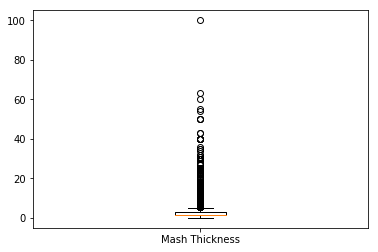

In [46]:
plt.boxplot(beer2['MashThickness'].dropna(), labels = ['Mash Thickness'])

MashThickness has a lot of really high outliers and the distribution is not normal. It probably makes more sense to replace nan values with the median than the mean.

In [47]:
np.median(beer2['MashThickness'].dropna())

1.5

The median for MashThickness is 1.5.

(array([4.4000e+01, 2.0000e+00, 3.0000e+00, 1.5000e+01, 3.5000e+01,
        5.0000e+00, 2.3000e+01, 5.0000e+00, 2.1000e+01, 1.0300e+02,
        2.0120e+03, 1.1590e+03, 2.2540e+03, 1.6954e+04, 2.2760e+04,
        4.5200e+03, 8.6600e+02, 1.3300e+02, 1.0000e+02, 6.0000e+00,
        1.6000e+01, 1.9000e+01, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        6.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00,
        3.0000e+00, 5.5000e+01, 3.3000e+01, 1.8000e+01, 4.0000e+00,
        4.0000e+00, 0.0000e+00, 5.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-17.78  , -15.1444, -12.5088,  -9.8732,  -7.2376,  -4.602 ,
         -1.9664,   0.6692,   3.3048,   5.9404,   8.576 ,  11.2116,
         13.8472,  16.4828,  19.1184,  21.754 ,  24.3896,  27.0252,
         29.6608,  32.2964,  34.932 ,  37.5676,  40.2032,  42.8388,
         45.4744,  48.11  ,  50.7456,  53.3812

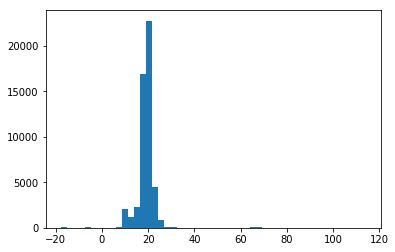

In [48]:
plt.hist(beer2['PrimaryTemp'].dropna(),bins = 50)


{'boxes': [<matplotlib.lines.Line2D at 0x115b06198>],
 'caps': [<matplotlib.lines.Line2D at 0x115b06ba8>,
 'fliers': [<matplotlib.lines.Line2D at 0x115b0e860>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x115b0e438>],
 'whiskers': [<matplotlib.lines.Line2D at 0x115b062e8>,
  <matplotlib.lines.Line2D at 0x115b06780>]}

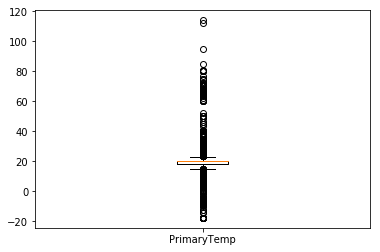

In [49]:
plt.boxplot(beer2['PrimaryTemp'].dropna(), labels = ['PrimaryTemp'])

In [50]:
np.median(beer2['PrimaryTemp'].dropna())

20.0

PrimaryTemp also has a lot of very high outliers. I'll replace nan values with the median.

(array([  51., 9477., 5469., 9002.,    0., 5194., 2405., 1838.,  533.,
         640.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

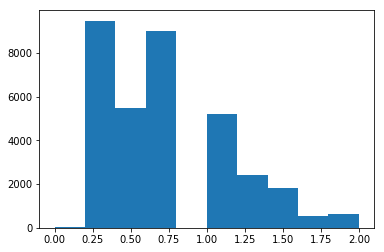

In [51]:
plt.hist(beer2['PitchRate'].dropna())

{'boxes': [<matplotlib.lines.Line2D at 0x10b595668>],
 'caps': [<matplotlib.lines.Line2D at 0x10b58b048>,
 'fliers': [<matplotlib.lines.Line2D at 0x113375da0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10b58be48>],
 'whiskers': [<matplotlib.lines.Line2D at 0x10b5958d0>,
  <matplotlib.lines.Line2D at 0x10b595d30>]}

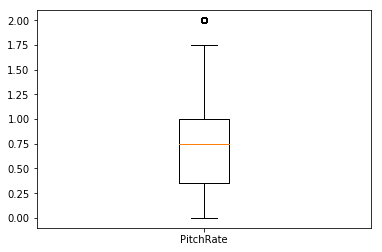

In [52]:
plt.boxplot(beer2['PitchRate'].dropna(), labels = ['PitchRate'])

In [53]:
np.median(beer2['PitchRate'].dropna())


0.75

In [54]:
np.mean(beer2['PitchRate'].dropna())

0.7504680863359242

I could use median or mean for PitchRate to replace the nan values.

In [55]:
beer2['PrimaryTemp2'] = beer2['PrimaryTemp'].fillna(20)

In [56]:
beer2['MashThickness2'] = beer2['MashThickness'].fillna(1.5)

In [57]:
beer2['PitchRate2'] = beer2['PitchRate'].fillna(0.75)

In [58]:
beer2 = beer2.drop(columns = ['MashThickness','PrimaryTemp','PitchRate'])

Finally I can drop all the empty fields from the 'kind' column I created and see how many rows I have left.

In [59]:
beer2.shape

(73861, 17)

In [60]:
beer3 = pd.DataFrame(beer2.dropna(how = 'any',axis = 0))

In [61]:
beer3.shape

(47154, 17)

In [62]:
beer3.tail()

,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,SugarScale,BrewMethod,kind,PrimaryTemp2,MashThickness2,PitchRate2
BeerID,,,,,,,,,,,,,,,,,
73855,10,18.93,1.064,1.016,6.26,0.00,9.60,28.39,60,1.042,75.0,Specific Gravity,BIAB,Pale Ale,20.0,1.5,0.75
73856,7,22.71,1.065,1.014,6.71,49.35,4.73,15.14,30,1.098,55.0,Specific Gravity,Partial Mash,IPA,20.0,1.5,0.50
73858,151,10.00,1.059,1.010,6.37,59.21,7.90,17.00,60,1.034,60.0,Specific Gravity,BIAB,IPA,22.0,1.5,0.50
73860,92,24.00,1.051,1.014,4.82,25.65,14.12,28.00,60,1.043,72.0,Specific Gravity,All Grain,Red Ale,18.0,1.5,0.75
73861,7,20.00,1.060,1.010,6.55,57.09,8.65,12.00,60,1.056,70.0,Specific Gravity,Partial Mash,IPA,18.0,1.5,0.75


In [63]:
beer3.corr()

,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,PrimaryTemp2,MashThickness2,PitchRate2
StyleID,1.000000,-0.002907,0.009492,0.015964,0.083530,-0.087259,0.269149,-0.001905,0.111623,0.009506,0.028521,0.025300,0.003063,0.056114
Size(L),-0.002907,1.000000,0.165110,0.145305,-0.012818,-0.040347,-0.018812,0.995146,0.046836,0.179065,0.113061,0.004012,0.041294,0.018627
OG,0.009492,0.165110,1.000000,0.947862,0.030220,-0.004228,0.020773,0.166234,0.033603,0.969408,0.070657,-0.001382,0.062589,0.013948
FG,0.015964,0.145305,0.947862,1.000000,0.032051,-0.004015,0.039907,0.146210,0.032790,0.919752,0.064449,0.002842,0.053432,0.008817
ABV,0.083530,-0.012818,0.030220,0.032051,1.000000,0.366478,0.275885,-0.008751,0.144261,0.025087,0.070013,0.030730,-0.048806,0.095455
IBU,-0.087259,-0.040347,-0.004228,-0.004015,0.366478,1.000000,0.009677,-0.039046,0.084911,-0.008578,-0.032696,0.017143,-0.046200,0.018785
Color,0.269149,-0.018812,0.020773,0.039907,0.275885,0.009677,1.000000,-0.017867,0.066109,0.018160,-0.019351,0.005746,-0.028582,0.018994
BoilSize,-0.001905,0.995146,0.166234,0.146210,-0.008751,-0.039046,-0.017867,1.000000,0.052399,0.178052,0.126376,0.003148,0.042468,0.021154
BoilTime,0.111623,0.046836,0.033603,0.032790,0.144261,0.084911,0.066109,0.052399,1.000000,0.030497,0.159071,-0.029376,0.039225,0.106356
BoilGravity,0.009506,0.179065,0.969408,0.919752,0.025087,-0.008578,0.018160,0.178052,0.030497,1.000000,0.060746,0.000326,0.063834,0.013277


In [64]:
# BoilGravity , OG are very highly correlated with FG.
# BoilSize is too highly correlated with Size(L)
beer3 = pd.DataFrame(beer3.drop(columns = ['OG','BoilGravity','BoilSize']))

In [65]:
beer3.shape

(47154, 14)

In [66]:
beer3dum = pd.get_dummies(beer3.drop(columns = ['kind','StyleID']))

In [67]:
beer3dum.head()

,Size(L),FG,ABV,IBU,Color,BoilTime,Efficiency,PrimaryTemp2,MashThickness2,PitchRate2,SugarScale_Plato,SugarScale_Specific Gravity,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract
BeerID,,,,,,,,,,,,,,,,
6,24.61,1.013,5.58,40.12,8.00,70,79.0,20.00,1.5,1.00,0,1,1,0,0,0
9,22.71,1.016,5.77,31.63,34.76,75,73.0,20.00,1.5,0.75,0,1,1,0,0,0
10,20.82,1.017,8.22,93.02,8.29,60,70.0,21.11,1.5,0.75,0,1,1,0,0,0
11,25.00,1.014,6.63,64.26,7.78,90,74.0,18.00,1.5,1.00,0,1,1,0,0,0
14,18.93,1.017,6.51,60.96,10.54,60,30.0,18.33,1.5,0.35,0,1,0,0,0,1


In [68]:
beer3dum.corr()

,Size(L),FG,ABV,IBU,Color,BoilTime,Efficiency,PrimaryTemp2,MashThickness2,PitchRate2,SugarScale_Plato,SugarScale_Specific Gravity,BrewMethod_All Grain,BrewMethod_BIAB,BrewMethod_Partial Mash,BrewMethod_extract
Size(L),1.000000,0.145305,-0.012818,-0.040347,-0.018812,0.046836,0.113061,0.004012,0.041294,0.018627,0.169539,-0.169539,0.091987,-0.060582,-0.025477,-0.048023
FG,0.145305,1.000000,0.032051,-0.004015,0.039907,0.032790,0.064449,0.002842,0.053432,0.008817,0.894397,-0.894397,0.070320,-0.042732,-0.019245,-0.041108
ABV,-0.012818,0.032051,1.000000,0.366478,0.275885,0.144261,0.070013,0.030730,-0.048806,0.095455,-0.008883,0.008883,0.033293,-0.020700,0.001880,-0.026022
IBU,-0.040347,-0.004015,0.366478,1.000000,0.009677,0.084911,-0.032696,0.017143,-0.046200,0.018785,-0.018844,0.018844,-0.007595,-0.012160,0.009183,0.019745
Color,-0.018812,0.039907,0.275885,0.009677,1.000000,0.066109,-0.019351,0.005746,-0.028582,0.018994,0.001600,-0.001600,0.007638,-0.007639,0.016663,-0.013047
BoilTime,0.046836,0.032790,0.144261,0.084911,0.066109,1.000000,0.159071,-0.029376,0.039225,0.106356,0.028178,-0.028178,0.156132,-0.029101,-0.058577,-0.159060
Efficiency,0.113061,0.064449,0.070013,-0.032696,-0.019351,0.159071,1.000000,-0.048810,0.099936,0.088364,0.071727,-0.071727,0.464986,0.098880,-0.115546,-0.731976
PrimaryTemp2,0.004012,0.002842,0.030730,0.017143,0.005746,-0.029376,-0.048810,1.000000,-0.005181,-0.152703,-0.003444,0.003444,-0.009500,-0.023639,0.012387,0.034115
MashThickness2,0.041294,0.053432,-0.048806,-0.046200,-0.028582,0.039225,0.099936,-0.005181,1.000000,0.011491,0.069068,-0.069068,0.206683,-0.134278,-0.063641,-0.105945
PitchRate2,0.018627,0.008817,0.095455,0.018785,0.018994,0.106356,0.088364,-0.152703,0.011491,1.000000,0.009292,-0.009292,0.062313,0.000573,-0.032212,-0.072224


In [69]:
#The Sugarscales are too strongly correlated with FG.
beer3dum = pd.DataFrame(beer3dum.drop(columns = ['SugarScale_Specific Gravity','SugarScale_Plato']))

In [70]:
##beer3dum = pd.DataFrame(beer3dum.drop(columns = ['BrewMethod_All Grain','BrewMethod_BIAB','BrewMethod_Partial Mash','BrewMethod_extract']))

In [71]:
beer3dum.shape

(47154, 14)

In [72]:
exes = beer3dum
columns = exes.columns
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(exes)
scaled_df = pd.DataFrame(scaled_df, columns = columns)
scaled_df.columns


Index(['Size(L)', 'FG', 'ABV', 'IBU', 'Color', 'BoilTime', 'Efficiency',
       'PrimaryTemp2', 'MashThickness2', 'PitchRate2', 'BrewMethod_All Grain',
       'BrewMethod_BIAB', 'BrewMethod_Partial Mash', 'BrewMethod_extract'],
      dtype='object')

In [73]:
beer3['kind'].nunique()

15

In [74]:
y = np.ravel(beer3['kind'])
y = y.astype(str)
X = scaled_df
# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
lr = LogisticRegression(C = 1e6)


In [75]:

##Fit the model.
fit = lr.fit(X, y)


In [76]:
# Display.
print('Coefficients')
print(fit.coef_[0])
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)
print('\n Percentage accuracy')
print(lr.score(X, y))

Coefficients
[ -0.80347098  -1.29848317 -14.74383833 -99.16540932 -11.93561353
  -0.65858809   0.6889097   -1.02835342  -0.62588131  -2.09113239
   0.43492316   0.32178294   0.50611669   0.35022427]
[  1.61304706  -1.37231923  -1.23860986  -1.05248572  -6.70366369
 -12.0482981    4.83987391  -0.12416528   1.2231524   -2.29457235
  -1.1724462   -6.31769147  -2.53577751  -2.05235583  -0.58517192]

 Percentage accuracy
0.4738092208508292


In [77]:
#freq = pd.DataFrame(beerna2['StyleID'].value_counts().reset_index())
#freqcut = pd.DataFrame(freq[freq['StyleID'] > 5])
#freqcut['index'].unique()

In [78]:
#freqcut['index'].nunique()

In [79]:
#beerna2cut = pd.DataFrame(beerna2.loc[beerna2['StyleID'].isin(freqcut['index'].unique())])
#beerna2cut['StyleID'].nunique()

In [80]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score


In [81]:
rfc = ensemble.RandomForestClassifier(n_jobs = -1)
y = np.ravel(beer3['kind'])
X = pd.DataFrame(beer3dum)


In [82]:
cross_val_score(rfc,X,y,cv=5)

array([0.59006145, 0.57901431, 0.58292683, 0.57786972, 0.56689655])

In [83]:
rfc.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

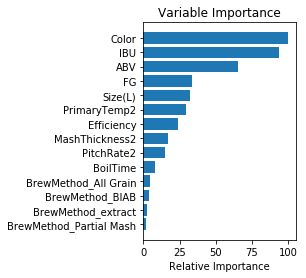

In [84]:

feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [85]:
# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [87]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params,subsample=.8)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)



In [88]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, predict_train, normalize=True, sample_weight=None)

0.6708610207832603

In [89]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predict_test, normalize=True, sample_weight=None)

0.5913910093299406